In [1]:
# Cell 1: imports and reproducibility
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib
import tensorflow as tf
import datetime

# Reproducibility (best-effort)
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# Matplotlib nicer defaults (no specific colors set; matplotlib chooses)
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 12


In [2]:
# Cell 2: load CSV - change filename/path as needed
csv_path = "wheat_Mysore_daily.csv"  # change if your filename differs

# If your CSV has two columns exactly as shown, adjust names below.
# Example header in question: "price date\tmodal price (rs./quintal)"
# We'll attempt to handle common variants automatically.
df = pd.read_csv(csv_path)

# Inspect first rows to ensure correct column names
print("Columns in CSV:", df.columns.tolist())
display(df.head())

# Normalize column detection: find date and price columns heuristically
# If your date column has 'date' in name and price column contains 'price' we'll pick them.
date_col = None
price_col = None
cols = [c.lower() for c in df.columns]

for orig, lower in zip(df.columns, cols):
    if 'date' in lower:
        date_col = orig
    if 'price' in lower or 'modal' in lower or 'quintal' in lower:
        price_col = orig

if date_col is None:
    # fallback to first column
    date_col = df.columns[0]
if price_col is None:
    # fallback to second column
    price_col = df.columns[1] if len(df.columns) > 1 else df.columns[0]

print("Using date col:", date_col)
print("Using price col:", price_col)

# Parse dates, sort, and keep necessary columns
df[date_col] = pd.to_datetime(df[date_col], dayfirst=False, errors='coerce')
df = df[[date_col, price_col]].dropna()
df = df.sort_values(by=date_col).reset_index(drop=True)
df.rename(columns={date_col: "date", price_col: "price"}, inplace=True)

# If price is string with commas, remove commas
df['price'] = df['price'].astype(str).str.replace(',', '').astype(float)

df.set_index('date', inplace=True)
print("Data range:", df.index.min(), "to", df.index.max())
display(df.head())


Columns in CSV: ['price date', 'modal price (rs./quintal)']


,price date,modal price (rs./quintal)
0,2020-01-01,2038.0
1,2020-01-02,2475.0
2,2020-01-03,2500.0
3,2020-01-04,2564.0
4,2020-01-05,2564.0


Using date col: price date
Using price col: modal price (rs./quintal)
Data range: 2020-01-01 00:00:00 to 2024-12-05 00:00:00


,price
date,
2020-01-01,2038.0
2020-01-02,2475.0
2020-01-03,2500.0
2020-01-04,2564.0
2020-01-05,2564.0


In [3]:
# Cell 3: windowing and scaling
lookback = 60  # previous 60 days
prices = df['price'].values.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0,1))
prices_scaled = scaler.fit_transform(prices)

# Build sequences X (lookback) -> y (next day)
X = []
y = []
for i in range(lookback, len(prices_scaled)):
    X.append(prices_scaled[i-lookback:i, 0])
    y.append(prices_scaled[i, 0])

X = np.array(X)
y = np.array(y)

# reshape for LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

print("X shape:", X.shape, "y shape:", y.shape)

# train/test split (e.g., last 10% as test)
split_idx = int(0.9 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Train samples:", X_train.shape[0], "Test samples:", X_test.shape[0])


X shape: (1741, 60, 1) y shape: (1741,)
Train samples: 1566 Test samples: 175


In [38]:
# Cell 4: model definition and training
from tensorflow.keras.layers import GRU

model = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()




# callbacks
os.makedirs('models', exist_ok=True)
checkpoint_path = "models/best_lstm.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
#early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[checkpoint],
    verbose=2
)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 60, 128)           50304     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 91,777
Trainable params: 91,777
Non-trainable params: 0
__________________________________________________

In [42]:
# Cell 5: save final artifacts
# The ModelCheckpoint already saved best weights to checkpoint_path; we'll also save the final model for convenience.
final_model_path = "models/final_lstm_model.h5"
model.save(final_model_path)
print("Saved model to:", final_model_path)

# Save scaler
scaler_path = "models/minmax_scaler.save"
joblib.dump(scaler, scaler_path)
print("Saved scaler to:", scaler_path)


Saved model to: models/final_lstm_model.h5
Saved scaler to: models/minmax_scaler.save


In [43]:
# Cell 6: load model & scaler for inference
from tensorflow.keras.models import load_model

loaded_model = load_model("models/best_lstm.h5")  # best checkpoint
loaded_scaler = joblib.load("models/minmax_scaler.save")

print("Loaded model and scaler.")


Loaded model and scaler.


In [44]:
# Cell 7: function to predict n steps ahead using iterative forecasting
def predict_n_days(model, scaler, last_60_array, n_days):
    """
    model: trained keras model
    scaler: fitted MinMaxScaler
    last_60_array: shape (60,) or (60,1) raw prices (NOT scaled)
    n_days: integer, number of days to forecast
    returns: list of predicted raw prices length n_days
    """
    # prepare
    arr = np.array(last_60_array).astype(float).reshape(-1,1)
    # if shape is (60,1) flatten to (60,)
    arr = arr.flatten()
    preds = []
    cur_window = arr.copy()
    for i in range(n_days):
        # scale
        cur_window_scaled = scaler.transform(cur_window.reshape(-1,1)).flatten()
        X_in = cur_window_scaled[-lookback:].reshape(1, lookback, 1)
        yhat_scaled = model.predict(X_in, verbose=0)[0,0]
        yhat_raw = scaler.inverse_transform(np.array([[yhat_scaled]]))[0,0]
        preds.append(float(yhat_raw))
        # append predicted value to window for next iteration
        cur_window = np.append(cur_window, yhat_raw)
    return preds


In [45]:
# Cell 8: prompt user for input or use last 60 days from dataset
print("Choose input method:")
print("1) Use last 60 days from CSV dataframe")
print("2) Paste 60 comma-separated prices (no dates)")

choice = input("Enter 1 or 2 (press Enter to default to 1): ").strip()
if choice == "" or choice == "1":
    # use last 60 observations from df
    if len(df) < lookback:
        raise ValueError(f"Not enough rows in CSV: need >= {lookback} rows.")
    last_60 = df['price'].values[-lookback:]
    source_note = f"Using last {lookback} days from CSV ending {df.index[-1].date()}"
else:
    raw = input(f"Paste {lookback} comma-separated numeric prices: ").strip()
    parts = [p.strip() for p in raw.split(",") if p.strip()!='']
    if len(parts) != lookback:
        raise ValueError(f"Expected {lookback} values but got {len(parts)}. Aborting.")
    last_60 = np.array(parts, dtype=float)
    source_note = "Using user-pasted 60 prices"

print(source_note)
print("Last 5 of input window:", last_60[-5:])

# Predict next 7 days and next 30 days
pred_7 = predict_n_days(loaded_model, loaded_scaler, last_60, 7)
pred_30 = predict_n_days(loaded_model, loaded_scaler, last_60, 30)

print("Next 7 days predictions:", [round(x,2) for x in pred_7])
print("Next 30 days predictions (first 7 shown):", [round(x,2) for x in pred_30[:7]])


Choose input method:
1) Use last 60 days from CSV dataframe
2) Paste 60 comma-separated prices (no dates)


Enter 1 or 2 (press Enter to default to 1):  2
Paste 60 comma-separated numeric prices:  3600,3600,3600,3599,3400,3400,3850,3850,3900,3900, 3900,3900,3900,3900,3700,3700,3650,3650,3680,3680, 3720,3720,3740,3740,3780,3780,3820,3820,3840,3840, 3860,3860,3880,3880,3890,3890,3900,3900,3885,3885, 3870,3870,3860,3860,3845,3845,3830,3830,3810,3810, 3790,3790,3760,3760,3730,3730,3700,3700,3680,3680


Using user-pasted 60 prices
Last 5 of input window: [3730. 3700. 3700. 3680. 3680.]
Next 7 days predictions: [3700.84, 3709.3, 3717.13, 3723.73, 3729.34, 3734.21, 3738.47]
Next 30 days predictions (first 7 shown): [3700.84, 3709.3, 3717.13, 3723.73, 3729.34, 3734.21, 3738.47]


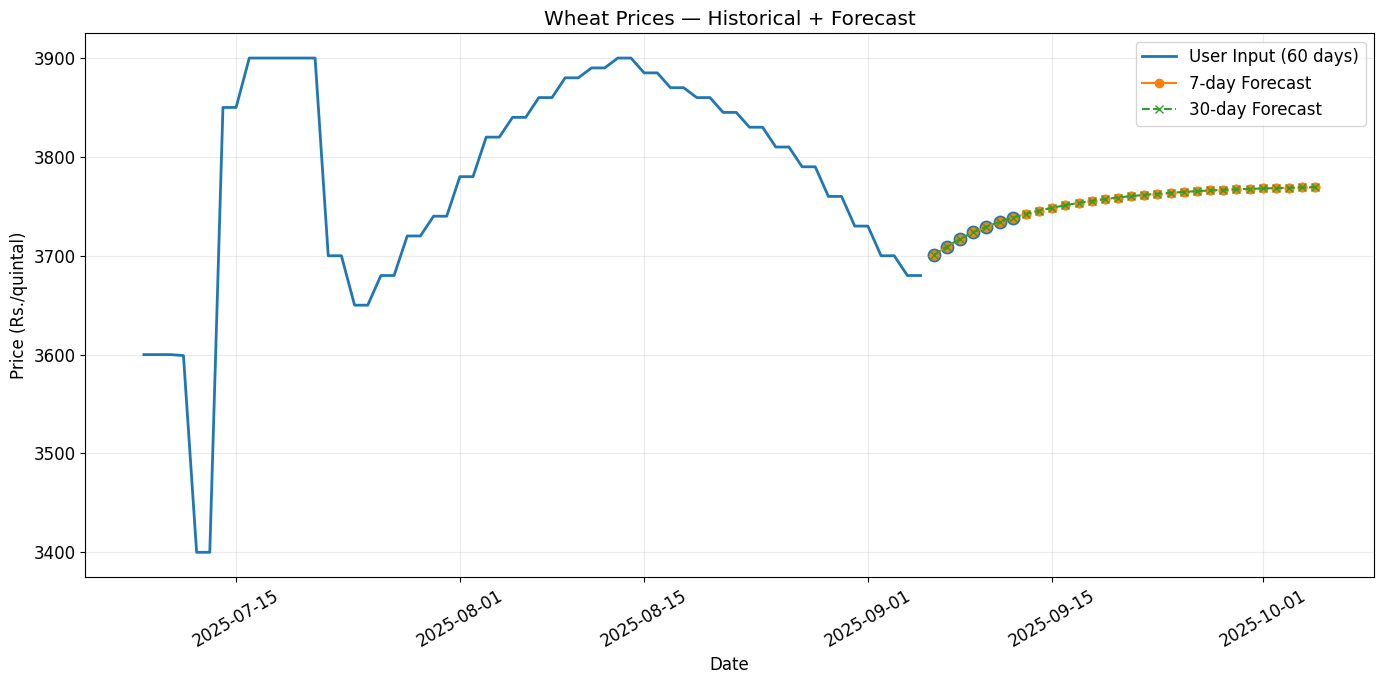

In [46]:
# Updated plotting logic

plt.figure(figsize=(14,7))

if choice == "" or choice == "1":
    # Case 1: using last 60 days from CSV
    last_date = df.index[-1]
    hist_df = df.copy()
    hist_to_show = 120
    if len(hist_df) > hist_to_show:
        hist_df = hist_df[-hist_to_show:]
    # plot full historical line
    plt.plot(hist_df.index, hist_df['price'], label='Historical Price (raw)', linewidth=2)

else:
    # Case 2: user pasted 60 values
    # Assume they are last 60 days ending today
    today = pd.Timestamp.today().normalize()
    dates_input = [today - pd.Timedelta(days=59-i) for i in range(60)]
    plt.plot(dates_input, last_60, label="User Input (60 days)", linewidth=2)
    last_date = today

# Forecast dates
dates_7 = [last_date + pd.Timedelta(days=i) for i in range(1, 8)]
dates_30 = [last_date + pd.Timedelta(days=i) for i in range(1, 31)]

# Plot predictions
plt.plot(dates_7, pred_7, label='7-day Forecast', linestyle='-', marker='o')
plt.scatter(dates_7, pred_7, s=80)

plt.plot(dates_30, pred_30, label='30-day Forecast', linestyle='--', marker='x')
plt.scatter(dates_30, pred_30, s=40)

plt.title('Wheat Prices — Historical + Forecast')
plt.xlabel('Date')
plt.ylabel('Price (Rs./quintal)')
plt.grid(alpha=0.25)
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [47]:
# Cell 10: save predictions to csv for further use
out = []
for d, p in zip(dates_7, pred_7):
    out.append({'date': d.date().isoformat(), 'horizon': '7_day', 'predicted_price': p})
for d, p in zip(dates_30, pred_30):
    out.append({'date': d.date().isoformat(), 'horizon': '30_day', 'predicted_price': p})

out_df = pd.DataFrame(out)
out_df.to_csv("wheat_price_predictions.csv", index=False)
print("Saved predictions to wheat_price_predictions.csv")
display(out_df.head(12))


Saved predictions to wheat_price_predictions.csv


,date,horizon,predicted_price
0,2025-09-06,7_day,3700.843750
1,2025-09-07,7_day,3709.301758
2,2025-09-08,7_day,3717.133057
3,2025-09-09,7_day,3723.727051
4,2025-09-10,7_day,3729.342773
5,2025-09-11,7_day,3734.207275
6,2025-09-12,7_day,3738.471436
7,2025-09-06,30_day,3700.843750
8,2025-09-07,30_day,3709.301758
9,2025-09-08,30_day,3717.133057


In [48]:
# Predict on test set
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# Accuracy metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


MAE: 117.78
RMSE: 153.95
R² Score: 0.7788


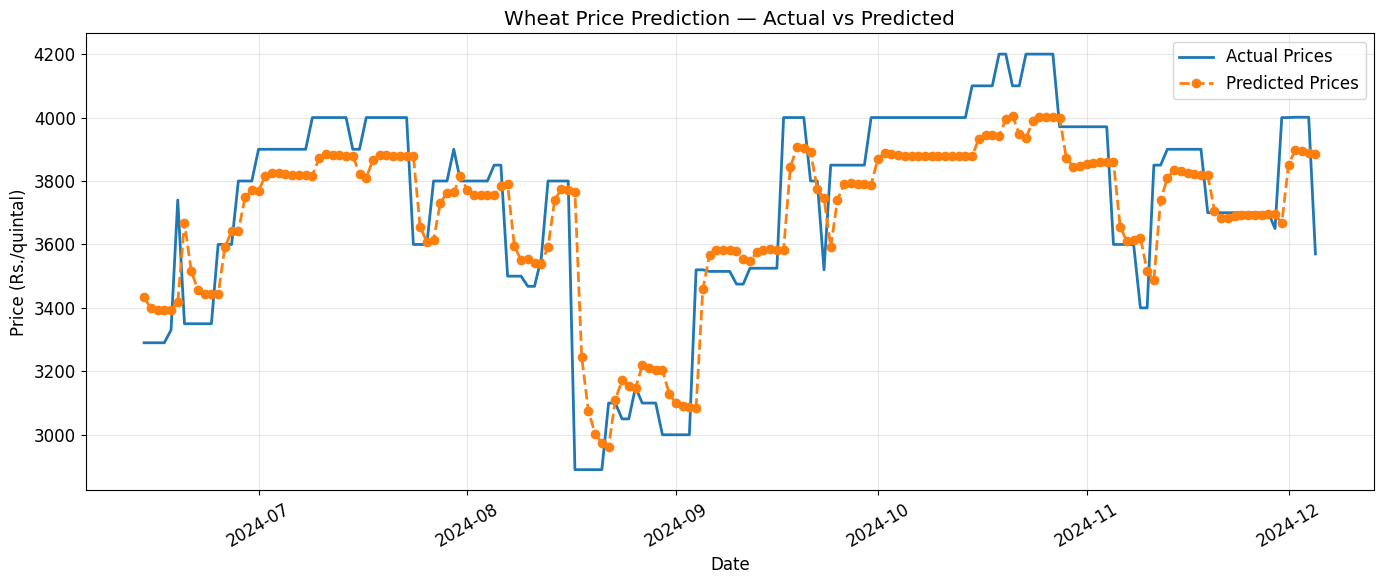

In [49]:
# Align dates for test period
test_dates = df.index[-len(y_true):]

plt.figure(figsize=(14,6))
plt.plot(test_dates, y_true, label="Actual Prices", linewidth=2)
plt.plot(test_dates, y_pred, label="Predicted Prices", linewidth=2, linestyle="--", marker="o")

plt.title("Wheat Price Prediction — Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price (Rs./quintal)")
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [50]:
import random

# pick a random index in test set
idx = random.randint(0, len(X_test)-1)

sample_X = X_test[idx:idx+1]   # shape (1,60,1)
sample_y_true = scaler.inverse_transform(y_test[idx].reshape(-1,1))[0,0]
sample_y_pred = scaler.inverse_transform(model.predict(sample_X))[0,0]

print("Ground Truth:", round(sample_y_true,2))
print("Predicted   :", round(sample_y_pred,2))


Ground Truth: 3570.0
Predicted   : 3883.65
